In [1]:
import torch 
!pip install pyro-ppl==1.3.0
import pyro
import numpy as np
import pyro.distributions as dist
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch.distributions.constraints as constraints
import time
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

     |████████████████████████████████| 495 kB 5.4 MB/s 


In [2]:
dataset = fashion_mnist.load_data()
(trainX, trainY), (testX, testY) = dataset

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
#rehsaping
trainX = np.reshape(trainX, (60000,784))
testX = np.reshape(testX, (10000,784))

trainX = torch.tensor(trainX)
trainY = torch.tensor(trainY)
testX = torch.tensor(testX)
testY = torch.tensor(testY)

In [4]:
#selection of first elements of dataset
trainX = trainX[:5000]
trainY = trainY[:5000]

testX = testX[:1000]
testY = testY[:1000]

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

torch.Size([5000, 784]) torch.Size([5000])
torch.Size([1000, 784]) torch.Size([1000])


In [5]:
#normalization

trainX = trainX.float()
for i in range(trainX.shape[0]):
  for j in range(trainX.shape[1]):
    trainX[i][j] = trainX[i][j]/255

In [6]:
#generative model

def model(x, y):
  '''
  x = trainX
  y = trainY
  '''
  n_obs, n_features = x.shape
  n_labels = 10
  x = x.float()

  w = pyro.sample("w", dist.Normal(torch.zeros(n_features, n_labels), 
                                   torch.ones(n_features, n_labels) )
                 )
  
  b = pyro.sample("b", dist.Normal(torch.zeros(n_labels), torch.ones(n_labels)))

  yhat = torch.mm(x,w) + b

  p = torch.softmax(yhat, dim=-1)

  with pyro.plate("data", len(y)):
    y = pyro.sample("y", dist.Categorical(probs=p), obs=y)


##################### guide ###########################################
def guide(x,y):
  n_obs, n_features = x.shape
  n_labels = 10
  x=x.float

  w_loc = pyro.param("w_loc", torch.rand(n_features, n_labels))
  w_scale = pyro.param("w_scale", torch.rand(n_features, n_labels), constraint=constraints.positive)
  w = pyro.sample("w", dist.Normal(w_loc, w_scale))

  b_loc = pyro.param("b_loc", torch.rand(n_labels))
  b_scale = pyro.param("b_scale", torch.rand(n_labels), constraint=constraints.positive)
  b = pyro.sample("b", dist.Normal(b_loc, b_scale))

In [17]:
start_time = time.time()

model_svi = pyro.infer.SVI(model=model, guide=guide, optim=pyro.optim.Adam({'lr':0.0001}), loss=pyro.infer.Trace_ELBO())

  # optim=pyro.optim.Adagrad({'lr':0.01})
  # optim=pyro.optim.Adam({'lr':0.0001})
  # optim=pyro.optim.RMSprop({'lr':0.01})
  # SGD non funziona

losses = []
for step in range(10000):
  loss = model_svi.step(trainX, trainY)/len(trainX)
  losses.append(loss)
  if step % 1000 == 0:
    print(f"step:{step} ; loss = {loss}")  
  
print(f"\n\n--- {round((time.time() - start_time)/60, ndigits=3)} minutes ---")  

step:0 ; loss = 1.8858030668258667


/usr/local/lib/python3.7/dist-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


ValueError: ignored

In [13]:
print("Inferred params:", list(pyro.get_param_store().keys()), end="\n\n")

inferred_w = pyro.get_param_store()["w_loc"]
inferred_b = pyro.get_param_store()["b_loc"]

print(f"w has shape ({inferred_w.shape[0]},{inferred_w.shape[1]})")
print(f"b has shape ({inferred_b.shape[0]})\n")

Inferred params: ['w_loc', 'w_scale', 'b_loc', 'b_scale']

w has shape (784,10)
b has shape (10)



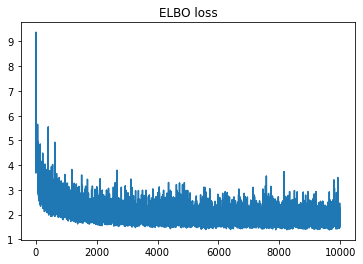

In [14]:
plt.title("ELBO loss")
plt.plot(losses)

In [15]:
w = pyro.get_param_store()["w_loc"]
b = pyro.get_param_store()["b_loc"]

def predict_class(x,w,b):
  n_obs, n_feat = x.shape

  x = x.float()
  scores = torch.mm(x,w) + b.repeat(n_obs, 1)

  probs = torch.softmax(scores, dim=-1)

  return torch.argmax(probs, dim=-1)

In [16]:
#overall accuracy

correct_predictions = (predict_class(testX,w,b) == testY).sum().item()
print(f"test accuracy over whole test set = {correct_predictions/len(testX)*100:.1f}%")

test accuracy over whole test set = 78.0%


In [ ]:
#classification report and confusion matrix

y_pred = predict_class(testX,w,b)

cf = confusion_matrix(testY, y_pred)
print("confusion matrix:\n", cf)

class_report = classification_report(testY, y_pred )
print("\n\nClassification report:\n", class_report)

confusion matrix:
 [[85  0  2 16  2  0  0  0  2  0]
 [ 5 94  0  5  1  0  0  0  0  0]
 [ 2  0 77  3 29  0  0  0  0  0]
 [ 6  2  0 82  3  0  0  0  0  0]
 [ 0  1 25 12 76  0  0  0  1  0]
 [ 0  0  0  0  0 45  0 39  3  0]
 [24  0 23  8 39  0  0  0  3  0]
 [ 0  0  0  0  0  6  0 88  1  0]
 [ 0  1  1  1  0  1  0  0 91  0]
 [ 0  0  0  0  1 85  0  9  0  0]]


Classification report:
               precision    recall  f1-score   support

           0       0.70      0.79      0.74       107
           1       0.96      0.90      0.93       105
           2       0.60      0.69      0.64       111
           3       0.65      0.88      0.75        93
           4       0.50      0.66      0.57       115
           5       0.33      0.52      0.40        87
           6       0.00      0.00      0.00        97
           7       0.65      0.93      0.76        95
           8       0.90      0.96      0.93        95
           9       0.00      0.00      0.00        95

    accuracy                

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
